# Read WWW for various car data
and create lqlite3 database

In [34]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import sqlite3
import re
from datetime import datetime, timedelta
from collections import OrderedDict
import time

import sqlalchemy as sa


strCarSalesQ=r'https://auto.vercity.ru/statistics/sales/europe/{year}/{country}/01-12/'
strCarProdsQ=r'https://auto.vercity.ru/statistics/production/europe/{year}/{country}/01-12/'

#conn=sqlite3.connect('cars.sqlite3') #connect or create database
eng_co=sa.create_engine('sqlite+pysqlite:///cars.sqlite3') #, echo=True)

In [59]:
class CarDataFrame(pd.DataFrame):

    @property
    def _constructor(self):
        return CarDataFrame

    def to_datetime(self, strField='date', format='%b-%Y'):
        self[strField]=pd.to_datetime(self[strField], format=format)
        return self
    
    def to_sql(self, name, con, flavor='sqlite', schema=None, if_exists='fail', index=True,
               index_label=None, chunksize=10, dtype=None):

        def drop_table(strTName):
            meta=sa.MetaData(bind=con)
            try:
                tbl_=sa.Table(strTName, meta, autoload=True, autoload_with=con)
                tbl_.drop(con, checkfirst=False)
            except:
                pass
        
        def create_table(strTName, strDateName='date', strModelName='Model', strCountName='Count'):
            metadata=sa.MetaData(bind=con)
            bname_t=sa.Table(strTName, metadata,
                        sa.Column(strDateName, sa.String, primary_key=True, nullable=False, autoincrement=False),
                        sa.Column(strModelName, sa.String, primary_key=True, nullable=False, autoincrement=False),
                        sa.Column(strCountName, sa.Float, primary_key=False, nullable=False, autoincrement=False))
            metadata.create_all()

        def buff_insert(alch_table, insert_prefix, values, buff_size=chunksize):
            def iterate_group(iterator, count):
                itr=iter(iterator)
                for i in range(0, len(iterator), count):
                    yield iterator[i:i+count]
        
            for i in iterate_group(values, buff_size):
                
                inserter = alch_table.insert(prefixes=insert_prefix, values=i)
                con.execute(inserter)
             
        if if_exists=='replace':
            drop_table(name)
            if_exists='fail'
        
        if not con.dialect.has_table(con, name):
            create_table(name)
            
        meta=sa.MetaData(bind=con)
        tbl_names=sa.Table(name, meta, autoload=True, autoload_with=con)
        vals=self.to_dict(orient='records')

        inserter=None

        if flavor == 'mysql':
            if if_exists in ['append', 'ignore']:
                inserter = tbl_names.insert(prefixes=['IGNORE'], values=vals)
            elif if_exists in ['update', 'upsert']:
                ins_state = sa.dialects.mysql.insert(tbl_names).values(vals)
                inserter = ins_state.on_duplicate_key_update(Date=ins_state.inserted.Date)
            elif if_exists=='fail':
                inserter = tbl_names.insert(values=vals)
            con.execute(inserter)
                
        if flavor == 'sqlite':
            if if_exists in ['append', 'ignore']:
                #inserter = tbl_names.insert(prefixes=['OR IGNORE'], values=vals)
                buff_insert(tbl_names, ['OR IGNORE'], vals, buff_size=chunksize)
            elif if_exists in ['update', 'upsert']:
                buff_insert(tbl_names, ['OR REPLACE'], vals, buff_size=chunksize)
                #inserter = tbl_names.insert(prefixes=['OR REPLACE'], values=vals)
            elif if_exists=='fail':
                buff_insert(tbl_names, None, vals, buff_size=chunksize)
        


In [36]:
startYear=2010
endYear=datetime.now().year+1

update_behaviour='replace'

def get_date_list(iYear):
        dates=['{0}-01-01'.format(iYear), '{0}-01-01'.format(iYear+1)]
        start, end=[datetime.strptime(_, '%Y-%m-%d') for _ in dates]
        od=OrderedDict(((start+timedelta(_)).strftime(r'%b-%Y'), None) for _ in range((end-start).days))
        return list(od.keys())

def GetYearsSalesData(curYear, strSource=strCarSalesQ, country='russia'):
    print('Reading from ', strSource.format(year=curYear, country=country), end=' ... ')
    
    r=requests.get(strSource.format(year=curYear, country=country))
    soup=BeautifulSoup(r.text, 'html.parser')
    
    lstHeads=['Model']+get_date_list(curYear)
    pdf=pd.DataFrame(columns=lstHeads)
    #print(pdf)

    lstVals=[]
    lstI=[1]+list(range(3, 15)) #+ [16] 

    for dv in soup.findAll('div', class_='pages_table-scrollable'):
        t=dv.table
        for tr in t.find_all('tr'):
            th=tr.find_all('th')
            if len(th)==0:
                tds=tr.find_all('td')
                if re.sub('\s', '', tds[1].text) =='N/A':
                    break
                lstVals=[re.sub('\s', '', c.text) for i, c in enumerate(tds) if i in lstI]
                pdf=pdf.append(pd.Series(lstVals, index=lstHeads), ignore_index=True)
    time.sleep(3)
    print('Year {year}, country {country}, reading {items} items'.format(year=curYear, country=country, items=pdf.shape))
    return pdf.set_index('Model')

#print(GetYearsSalesData(2010).stack())


def crawldata(strURL, start_year=startYear, end_year=endYear, country='russia'):
    sales_df=pd.concat([GetYearsSalesData(Y, strSource=strURL, country=country) for Y in range(start_year, end_year)], axis=1) 

    sales_df=sales_df.stack().reset_index().rename(columns={'level_0':'Model', 'level_1':'date', 0:'Count'})
    sales_df['Count']=sales_df['Count'].apply(pd.to_numeric)

    sales_df['date']=pd.to_datetime(sales_df['date'], format='%b-%Y')
    sales_df=sales_df.sort_values(by='date', inplace=False, ascending=True)
    sales_df['date']=sales_df['date'].dt.strftime('%b-%Y')
    
    return CarDataFrame(sales_df[sales_df['Count']!=0])

## 1. Car sales (https://auto.vercity.ru/statistics/sales/)
###  For Russia

https://auto.vercity.ru/statistics/sales/europe/2010/russia/01-12/

In [27]:
sales_ru=crawldata(strCarSalesQ)

sales_ru.to_sql('sales_ru', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_ru.tail(12))


Reading from ... https://auto.vercity.ru/statistics/sales/europe/2010/russia/01-12/ ... Year 2010, country russia, reading (73, 13) items
Reading from ... https://auto.vercity.ru/statistics/sales/europe/2011/russia/01-12/ ... Year 2011, country russia, reading (72, 13) items
Reading from ... https://auto.vercity.ru/statistics/sales/europe/2012/russia/01-12/ ... Year 2012, country russia, reading (70, 13) items
Reading from ... https://auto.vercity.ru/statistics/sales/europe/2013/russia/01-12/ ... Year 2013, country russia, reading (70, 13) items
Reading from ... https://auto.vercity.ru/statistics/sales/europe/2014/russia/01-12/ ... Year 2014, country russia, reading (70, 13) items
Reading from ... https://auto.vercity.ru/statistics/sales/europe/2015/russia/01-12/ ... Year 2015, country russia, reading (70, 13) items
Reading from ... https://auto.vercity.ru/statistics/sales/europe/2016/russia/01-12/ ... Year 2016, country russia, reading (62, 13) items
Reading from ... https://auto.verc

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



        Model      date  Count
6500    Volvo  Sep-2018    904
6284   Toyota  Sep-2018  11237
6176   Suzuki  Sep-2018    621
2984   Hawtai  Sep-2018     13
3452    Isuzu  Sep-2018     66
1940  Emgrand  Sep-2018     25
4292    Lexus  Sep-2018   2247
2480    Geely  Sep-2018    337
2372    Foton  Sep-2018     26
908   ChangAn  Sep-2018    142


### For Ukraine - https://auto.vercity.ru/statistics/sales/europe/2018/ukraine/

In [29]:
sales_ukraine=crawldata(strCarSalesQ, country='ukraine')

sales_ukraine.to_sql('sales_ukraine', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_ukraine.tail(12))

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/ukraine/01-12/ ... Year 2010, country ukraine, reading (54, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/ukraine/01-12/ ... Year 2011, country ukraine, reading (54, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/ukraine/01-12/ ... Year 2012, country ukraine, reading (54, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/ukraine/01-12/ ... Year 2013, country ukraine, reading (54, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/ukraine/01-12/ ... Year 2014, country ukraine, reading (54, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/ukraine/01-12/ ... Year 2015, country ukraine, reading (51, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/ukraine/01-12/ ... Year 2016, country ukraine, reading (50, 13) items
Reading from  https://auto.vercity.ru/sta

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



           Model      date  Count
2658       Mazda  Jul-2018    233
1086        Ford  Jul-2018    307
102         Audi  Jul-2018     92
4422      Toyota  Jul-2018    853
2970  Mitsubishi  Jul-2018    158
2118         Kia  Jul-2018    438
210          BMW  Jul-2018    212
4242      Suzuki  Jul-2018    261
3186        Opel  Jul-2018     10
978         Fiat  Jul-2018     76
702      Citroen  Jul-2018    144
1602     Hyundai  Jul-2018    451


### Poland - https://auto.vercity.ru/statistics/sales/europe/2018/poland/

In [30]:
sales_poland=crawldata(strCarSalesQ, country='poland')

sales_poland.to_sql('sales_ploand', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_poland.tail(12))

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/poland/01-12/ ... Year 2010, country poland, reading (75, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/poland/01-12/ ... Year 2011, country poland, reading (75, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/poland/01-12/ ... Year 2012, country poland, reading (73, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/poland/01-12/ ... Year 2013, country poland, reading (71, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/poland/01-12/ ... Year 2014, country poland, reading (67, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/poland/01-12/ ... Year 2015, country poland, reading (65, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/poland/01-12/ ... Year 2016, country poland, reading (65, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



              Model      date  Count
6296         Subaru  Sep-2018     88
1520          Dacia  Sep-2018   1818
6404         Suzuki  Sep-2018    515
6968          Volvo  Sep-2018    794
1988           Fiat  Sep-2018    286
2936           Jeep  Sep-2018    217
4088            MAN  Sep-2018      3
4376          Mazda  Sep-2018    923
2420        Hyundai  Sep-2018   1287
5132           Opel  Sep-2018   1590
6188      SsangYong  Sep-2018     17
4592  Mercedes-Benz  Sep-2018   1066


### Belarus - https://auto.vercity.ru/statistics/sales/europe/2018/belarus/

In [31]:
sales_belarus=crawldata(strCarSalesQ, country='belarus')

sales_belarus.to_sql('sales_belarus', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_belarus.tail(12))

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/belarus/01-12/ ... Year 2010, country belarus, reading (5, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/belarus/01-12/ ... Year 2011, country belarus, reading (5, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/belarus/01-12/ ... Year 2012, country belarus, reading (5, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/belarus/01-12/ ... Year 2013, country belarus, reading (5, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/belarus/01-12/ ... Year 2014, country belarus, reading (3, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/belarus/01-12/ ... Year 2015, country belarus, reading (3, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/belarus/01-12/ ... Year 2016, country belarus, reading (3, 13) items
Reading from  https://auto.vercity.ru/statistics

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



    Model      date  Count
379   МАЗ  Aug-2017    592
380   МАЗ  Sep-2017    628
381   МАЗ  Oct-2017    712
382   МАЗ  Nov-2017    947
383   МАЗ  Dec-2017   1074
384   МАЗ  Jan-2018    569
385   МАЗ  Feb-2018    528
386   МАЗ  Mar-2018    974
387   МАЗ  Apr-2018    579
388   МАЗ  May-2018    768
389   МАЗ  Jun-2018    967
390   МАЗ  Jul-2018    636


### Germany -https://auto.vercity.ru/statistics/sales/europe/2018/germany/

In [32]:
sales_germany=crawldata(strCarSalesQ, country='germany')

sales_germany.to_sql('sales_germany', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_germany.tail(12))

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/germany/01-12/ ... Year 2010, country germany, reading (82, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/germany/01-12/ ... Year 2011, country germany, reading (82, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/germany/01-12/ ... Year 2012, country germany, reading (82, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/germany/01-12/ ... Year 2013, country germany, reading (78, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/germany/01-12/ ... Year 2014, country germany, reading (74, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/germany/01-12/ ... Year 2015, country germany, reading (73, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/germany/01-12/ ... Year 2016, country germany, reading (71, 13) items
Reading from  https://auto.vercity.ru/sta

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



            Model      date  Count
7364        Tesla  Sep-2018    185
5936  Rolls-Royce  Sep-2018      7
4040    LandRover  Sep-2018    973
2204         Fiat  Sep-2018   5622
6500        Smart  Sep-2018   2273
7796   Volkswagen  Sep-2018  20215
104     AlfaRomeo  Sep-2018    215
2756      Hyundai  Sep-2018   8579
5828      Renault  Sep-2018   5078
2312         Ford  Sep-2018  14994
1640        Dacia  Sep-2018   2083
968      Cadillac  Sep-2018      8


### France - https://auto.vercity.ru/statistics/sales/europe/2018/france/

In [37]:
sales_france=crawldata(strCarSalesQ, country='france')

sales_france.to_sql('sales_france', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_france.tail(12))

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/france/01-12/ ... Year 2010, country france, reading (76, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/france/01-12/ ... Year 2011, country france, reading (76, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/france/01-12/ ... Year 2012, country france, reading (75, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/france/01-12/ ... Year 2013, country france, reading (75, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/france/01-12/ ... Year 2014, country france, reading (70, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/france/01-12/ ... Year 2015, country france, reading (67, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/france/01-12/ ... Year 2016, country france, reading (63, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



            Model      date  Count
859      Cadillac  Aug-2018      2
6163        Smart  Aug-2018    551
427          Audi  Aug-2018   5052
2335      Hyundai  Aug-2018   2124
3895     Liebherr  Aug-2018      6
1231          DAF  Aug-2018    289
4615   Mitsubishi  Aug-2018    782
2227        Honda  Aug-2018    488
967     Chevrolet  Aug-2018      2
103     AlfaRomeo  Aug-2018   1404
319   AstonMartin  Aug-2018      9
2119      Heuliez  Aug-2018     23


### United Kingdom - https://auto.vercity.ru/statistics/sales/europe/2018/united_kingdom/

In [38]:
sales_uk=crawldata(strCarSalesQ, country='united_kingdom')

sales_uk.to_sql('sales_uk', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_uk.tail(12))

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/united_kingdom/01-12/ ... Year 2010, country united_kingdom, reading (94, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/united_kingdom/01-12/ ... Year 2011, country united_kingdom, reading (76, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/united_kingdom/01-12/ ... Year 2012, country united_kingdom, reading (75, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/united_kingdom/01-12/ ... Year 2013, country united_kingdom, reading (74, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/united_kingdom/01-12/ ... Year 2014, country united_kingdom, reading (73, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/united_kingdom/01-12/ ... Year 2015, country united_kingdom, reading (73, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/united_kingdom/01-12/ ... Y

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



              Model      date  Count
3055          Iveco  Aug-2018    270
1099      Chevrolet  Aug-2018      1
811         Bentley  Aug-2018    160
1855        Ferrari  Aug-2018     45
1483             DS  Aug-2018     88
7267       Vauxhall  Aug-2018   5664
4579  Mercedes-Benz  Aug-2018   7147
1591          Dacia  Aug-2018    818
3163         Jaguar  Aug-2018   1242
2947          Isuzu  Aug-2018    239
5767    Rolls-Royce  Aug-2018     15
5407        Peugeot  Aug-2018   5875


### China - https://auto.vercity.ru/statistics/sales/asia/2018/china/

In [39]:
sales_china=crawldata(strCarSalesQ, country='china')

sales_china.to_sql('sales_china', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_china.tail(12))

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/china/01-12/ ... Year 2010, country china, reading (126, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/china/01-12/ ... Year 2011, country china, reading (123, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/china/01-12/ ... Year 2012, country china, reading (122, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/china/01-12/ ... Year 2013, country china, reading (119, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/china/01-12/ ... Year 2014, country china, reading (119, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/china/01-12/ ... Year 2015, country china, reading (118, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/china/01-12/ ... Year 2016, country china, reading (117, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



           Model      date   Count
103        Acura  Aug-2018     634
5851    Huanghai  Aug-2018    1817
4339       Geely  Aug-2018   63102
4771   GreatWall  Aug-2018   10997
10723     Suzuki  Aug-2018    2814
10831     Toyota  Aug-2018  111280
10399      Skoda  Aug-2018   28800
12667  Zhongtong  Aug-2018     575
7471         Kia  Aug-2018   20000
1723    Cadillac  Aug-2018   16000
12343       Yema  Aug-2018    3294
643          BYD  Aug-2018   41846


### Japan - https://auto.vercity.ru/statistics/sales/asia/2018/japan/

In [41]:
sales_japan=crawldata(strCarSalesQ, country='japan')

sales_japan.to_sql('sales_japan', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_japan.tail(12))

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/japan/01-12/ ... Year 2010, country japan, reading (68, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/japan/01-12/ ... Year 2011, country japan, reading (67, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/japan/01-12/ ... Year 2012, country japan, reading (67, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/japan/01-12/ ... Year 2013, country japan, reading (67, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/japan/01-12/ ... Year 2014, country japan, reading (65, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/japan/01-12/ ... Year 2015, country japan, reading (64, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/japan/01-12/ ... Year 2016, country japan, reading (62, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2017/ja

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



              Model      date  Count
3368    Lamborghini  Sep-2018     37
1736       Daihatsu  Sep-2018  54074
692             BMW  Sep-2018   5861
2168           Fiat  Sep-2018    587
3692          Lexus  Sep-2018   3550
2492           Hino  Sep-2018   7532
1952          Dodge  Sep-2018     35
6440         Suzuki  Sep-2018  65205
5204        Pontiac  Sep-2018      1
3908             MG  Sep-2018      3
1232      Chevrolet  Sep-2018     78
4448  Mercedes-Benz  Sep-2018   7016


### USA - https://auto.vercity.ru/statistics/sales/north_america/2018/united_states/

In [42]:
sales_usa=crawldata(strCarSalesQ, country='united_states')

sales_usa.to_sql('sales_usa', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_usa.tail(12))


Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/united_states/01-12/ ... Year 2010, country united_states, reading (60, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/united_states/01-12/ ... Year 2011, country united_states, reading (60, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/united_states/01-12/ ... Year 2012, country united_states, reading (57, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/united_states/01-12/ ... Year 2013, country united_states, reading (54, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/united_states/01-12/ ... Year 2014, country united_states, reading (54, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/united_states/01-12/ ... Year 2015, country united_states, reading (52, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/united_states/01-12/ ... Year 2016, cou

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



              Model      date   Count
644         Bentley  Sep-2018     150
1508           Ford  Sep-2018  188328
5252         Subaru  Sep-2018   57044
320     AstonMartin  Sep-2018      82
3044            Kia  Sep-2018   51503
5528         Toyota  Sep-2018  178501
4616        Porsche  Sep-2018    5102
5420          Tesla  Sep-2018   29900
752           Buick  Sep-2018   14951
4016  Mercedes-Benz  Sep-2018   30617
1292        Ferrari  Sep-2018     171
968       Chevrolet  Sep-2018  157845


### India - https://auto.vercity.ru/statistics/sales/asia/2018/india/

In [43]:
sales_india=crawldata(strCarSalesQ, country='india')

sales_india.to_sql('sales_india', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_india.tail(12))

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/india/01-12/ ... Year 2010, country india, reading (36, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/india/01-12/ ... Year 2011, country india, reading (36, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/india/01-12/ ... Year 2012, country india, reading (34, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/india/01-12/ ... Year 2013, country india, reading (34, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/india/01-12/ ... Year 2014, country india, reading (34, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/india/01-12/ ... Year 2015, country india, reading (34, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/india/01-12/ ... Year 2016, country india, reading (33, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2017/in

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



           Model      date   Count
967       Eicher  Aug-2018    4843
2995       Skoda  Aug-2018    1330
1603     Hyundai  Aug-2018   45801
2455  Mitsubishi  Aug-2018      26
3103   SsangYong  Aug-2018      27
3535  Volkswagen  Aug-2018    3334
2563      Nissan  Aug-2018     530
3427      Toyota  Aug-2018   14136
3211      Suzuki  Aug-2018  147700
1891         JBM  Aug-2018      20
859       Datsun  Aug-2018    2578
2107        Jeep  Aug-2018    1302


### Brasil - https://auto.vercity.ru/statistics/sales/south_america/2018/brazil/

In [45]:
sales_brazil=crawldata(strCarSalesQ, country='brazil')

sales_brazil.to_sql('sales_brazil', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_brazil.tail(12))

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/brazil/01-12/ ... Year 2010, country brazil, reading (81, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/brazil/01-12/ ... Year 2011, country brazil, reading (80, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/brazil/01-12/ ... Year 2012, country brazil, reading (78, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/brazil/01-12/ ... Year 2013, country brazil, reading (75, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/brazil/01-12/ ... Year 2014, country brazil, reading (71, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/brazil/01-12/ ... Year 2015, country brazil, reading (70, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/brazil/01-12/ ... Year 2016, country brazil, reading (61, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



              Model      date  Count
1772          Dodge  Sep-2018     79
5684        Peugeot  Sep-2018   1679
5552         Nissan  Sep-2018   7964
1028          Chery  Sep-2018   1002
6260         Scania  Sep-2018    702
1544            DAF  Sep-2018    218
7064         Toyota  Sep-2018  16614
1244       Chrysler  Sep-2018      7
3260  International  Sep-2018      1
4964      Marcopolo  Sep-2018    185
3116        Hyundai  Sep-2018  16629
4508          Lifan  Sep-2018     98


### SAR - https://auto.vercity.ru/statistics/sales/africa/2018/south_africa/

In [49]:
sales_sar=crawldata(strCarSalesQ, country='south_africa')

sales_sar.to_sql('sales_sar', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_sar.tail(12))

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/south_africa/01-12/ ... Year 2010, country south_africa, reading (76, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/south_africa/01-12/ ... Year 2011, country south_africa, reading (73, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/south_africa/01-12/ ... Year 2012, country south_africa, reading (68, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/south_africa/01-12/ ... Year 2013, country south_africa, reading (67, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/south_africa/01-12/ ... Year 2014, country south_africa, reading (67, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/south_africa/01-12/ ... Year 2015, country south_africa, reading (66, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/south_africa/01-12/ ... Year 2016, country south_af

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



          Model      date  Count
6403     Subaru  Aug-2018     85
5959     Scania  Aug-2018    236
211   AlfaRomeo  Aug-2018      8
6511     Suzuki  Aug-2018   1081
1855     Eicher  Aug-2018      9
4291   Landwind  Aug-2018     12
1615     Datsun  Aug-2018    721
103      Abarth  Aug-2018      4
3523      Iveco  Aug-2018    136
4747   Maserati  Aug-2018      5
6187      Smart  Aug-2018     22
6835   UDTrucks  Aug-2018    224


### Korea - https://auto.vercity.ru/statistics/sales/asia/2018/south_korea/

In [50]:
sales_korea=crawldata(strCarSalesQ, country='south_korea')

sales_korea.to_sql('sales_korea', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_korea.tail(12))

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/south_korea/01-12/ ... Year 2010, country south_korea, reading (41, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/south_korea/01-12/ ... Year 2011, country south_korea, reading (40, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/south_korea/01-12/ ... Year 2012, country south_korea, reading (40, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/south_korea/01-12/ ... Year 2013, country south_korea, reading (39, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/south_korea/01-12/ ... Year 2014, country south_korea, reading (37, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/south_korea/01-12/ ... Year 2015, country south_korea, reading (36, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/south_korea/01-12/ ... Year 2016, country south_korea, reading 

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



              Model      date  Count
535        Cadillac  Aug-2018    242
1555          Honda  Aug-2018    724
1075         Daewoo  Aug-2018   1188
3055         Nissan  Aug-2018    459
3163        Peugeot  Aug-2018    512
2779  Mercedes-Benz  Aug-2018   3019
967              DS  Aug-2018      1
2419          Lexus  Aug-2018    560
3271        Porsche  Aug-2018    416
3979     Volkswagen  Aug-2018   1820
2527        Lincoln  Aug-2018    318
427         Bentley  Aug-2018     16


### Italy - https://auto.vercity.ru/statistics/sales/europe/2018/italy/

In [52]:
sales_italy=crawldata(strCarSalesQ, country='italy')

sales_italy.to_sql('sales_italy', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_italy.tail(12))

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/italy/01-12/ ... Year 2010, country italy, reading (102, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/italy/01-12/ ... Year 2011, country italy, reading (83, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/italy/01-12/ ... Year 2012, country italy, reading (83, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/italy/01-12/ ... Year 2013, country italy, reading (82, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/italy/01-12/ ... Year 2014, country italy, reading (81, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/italy/01-12/ ... Year 2015, country italy, reading (78, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/italy/01-12/ ... Year 2016, country italy, reading (77, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2017/i

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



           Model      date  Count
7927  Volkswagen  Aug-2018   6924
1663     Citroen  Aug-2018   4734
3367    Infiniti  Aug-2018     93
5695        Opel  Aug-2018   4788
1519   Chevrolet  Aug-2018      1
7183      Suzuki  Aug-2018   1219
7075      Subaru  Aug-2018    163
3475       Isuzu  Aug-2018     44
5971     Peugeot  Aug-2018   5402
5587      Nissan  Aug-2018   2649
4951    Maserati  Aug-2018    112
2755        Ford  Aug-2018   6960


### For test: some grouping and plotting

<IPython.core.display.Javascript object>


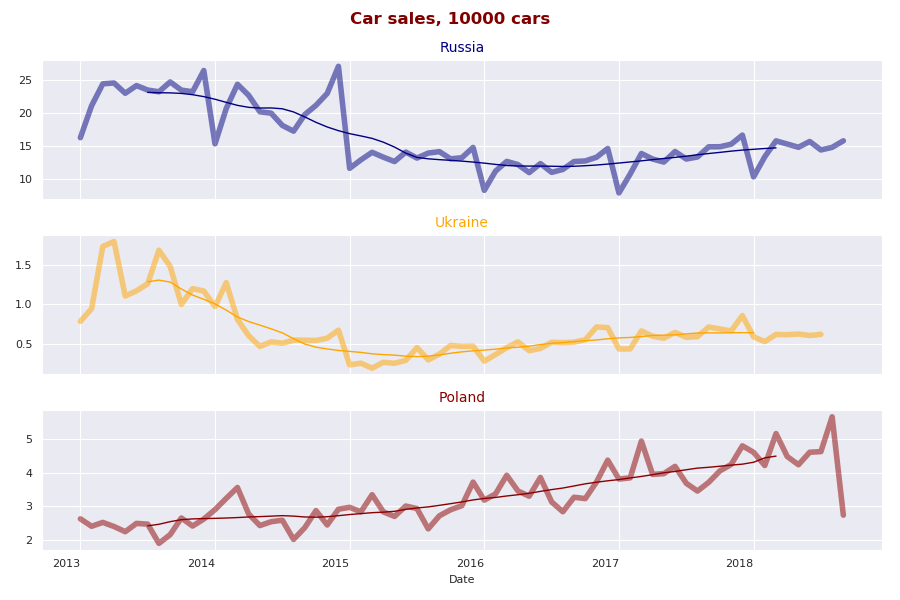

In [117]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import rc
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib notebook

#sns.set_style('whitegrid')
sns.set_style('dark')

iStartYear=2013

country1=[CarDataFrame(sales_ru), CarDataFrame(sales_ukraine), CarDataFrame(sales_poland)]
country2=[CarDataFrame(sales_germany), CarDataFrame(sales_uk), CarDataFrame(sales_france)]
country3=[CarDataFrame(sales_china), CarDataFrame(sales_usa), CarDataFrame(sales_japan)]
country4=[CarDataFrame(sales_india), CarDataFrame(sales_brazil), CarDataFrame(sales_sar)]


def plot_triple(frames, names, colors, mst=1e4):

    lst1=[pdf.to_datetime()[pdf['date'].dt.year >=iStartYear].groupby(pd.Grouper(key='date', freq='M'))['Count'].sum()/mst for pdf in frames]
    lst1[0].name=names[0]
    lst1[1].name=names[1]
    lst1[2].name=names[2]
    ax0, ax1, ax2=pd.concat(lst1, axis=1).plot.line(subplots=True, sharex=True, figsize=(9, 6), 
                                                    color=colors, rot=0, fontsize=8, lw=4, alpha=0.5, legend=False)

    ax0.set_title(names[0], fontsize=10, color=colors[0])
    pdfRu_trend=seasonal_decompose(lst1[0], model='additive', freq=12).trend
    pdfRu_trend.plot.line(ax=ax0, legend=False, color=colors[0], grid=True, fontsize=10, lw=1)


    ax1.set_title(names[1], fontsize=10, color=colors[1])
    pdfUkr_trend=seasonal_decompose(lst1[1], model='additive', freq=12).trend
    pdfUkr_trend.plot.line(ax=ax1, legend=False, color=colors[1], grid=True, fontsize=10, lw=1)

    ax2.set_title(names[2], fontsize=10, color=colors[2])
    pdfPol_trend=seasonal_decompose(lst1[2], model='additive', freq=12).trend
    pdfPol_trend.plot.line(ax=ax2, legend=False, color=colors[2], grid=True, fontsize=10, lw=1)

    ax0.tick_params(axis='both', which='major', labelsize=8)
    ax1.tick_params(axis='both', which='major', labelsize=8)
    ax2.tick_params(axis='both', which='major', labelsize=8)
    ax2.set_xlabel('Date', fontsize=8)
    plt.tight_layout()
    
    st=plt.gcf().suptitle('Car sales, {:.0f} cars'.format(mst), fontsize=12, color='maroon', weight='bold')
    plt.gcf().subplots_adjust(top=0.9)
    plt.show();
    return plt

plot_triple(country1, ['Russia', 'Ukraine', 'Poland'], ['navy', 'orange', 'darkred']).savefig(r'/home/egor/Изображения/car_sales_ru-ukr-pol.png')

<IPython.core.display.Javascript object>


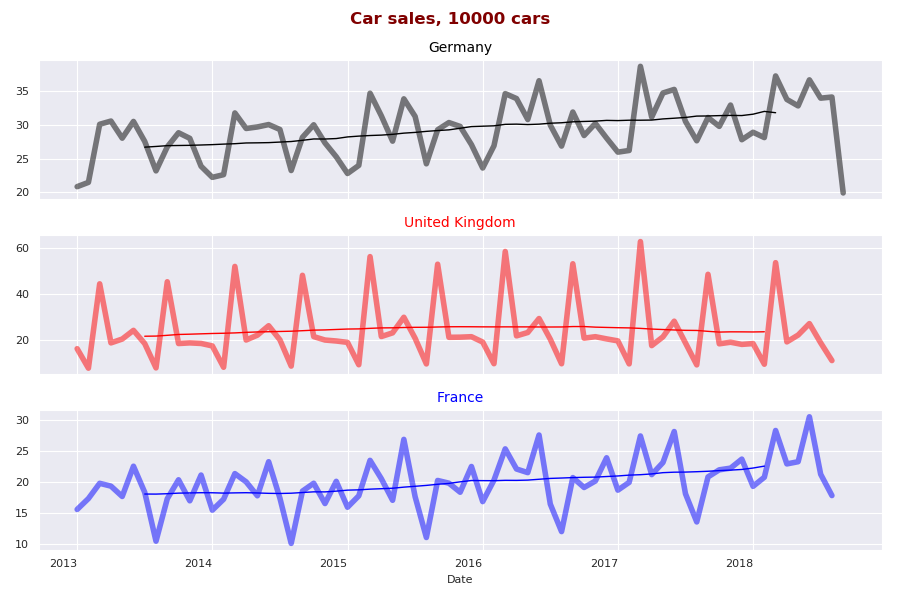

In [119]:
plot_triple(country2, ['Germany', 'United Kingdom', 'France'], ['black', 'red', 'blue']).savefig(r'/home/egor/Изображения/car_sales_ger_uk_fra.png')

<IPython.core.display.Javascript object>


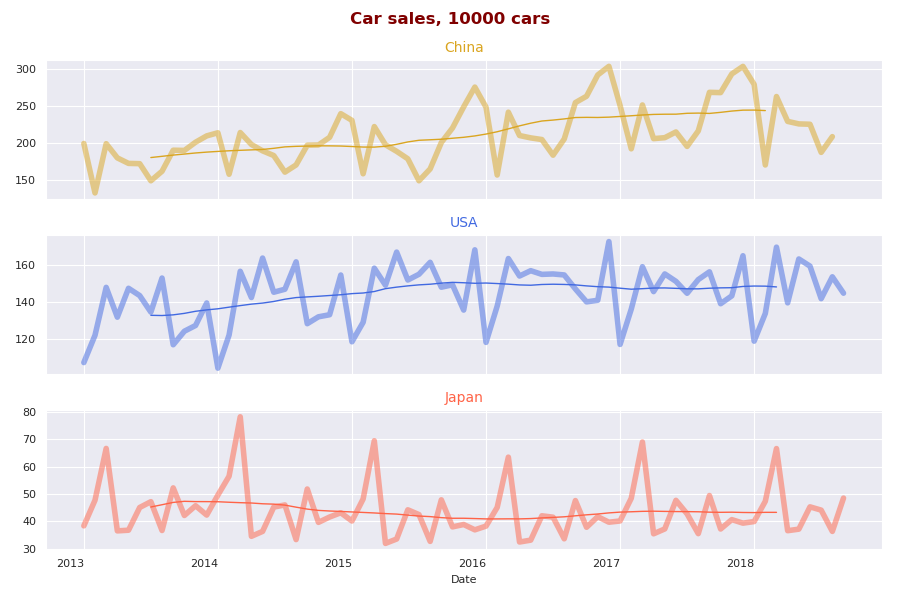

In [120]:
plot_triple(country3, ['China', 'USA', 'Japan'], ['goldenrod', 'royalblue', 'tomato']).savefig(r'/home/egor/Изображения/car_sales_ch_usa_jp.png')

<IPython.core.display.Javascript object>


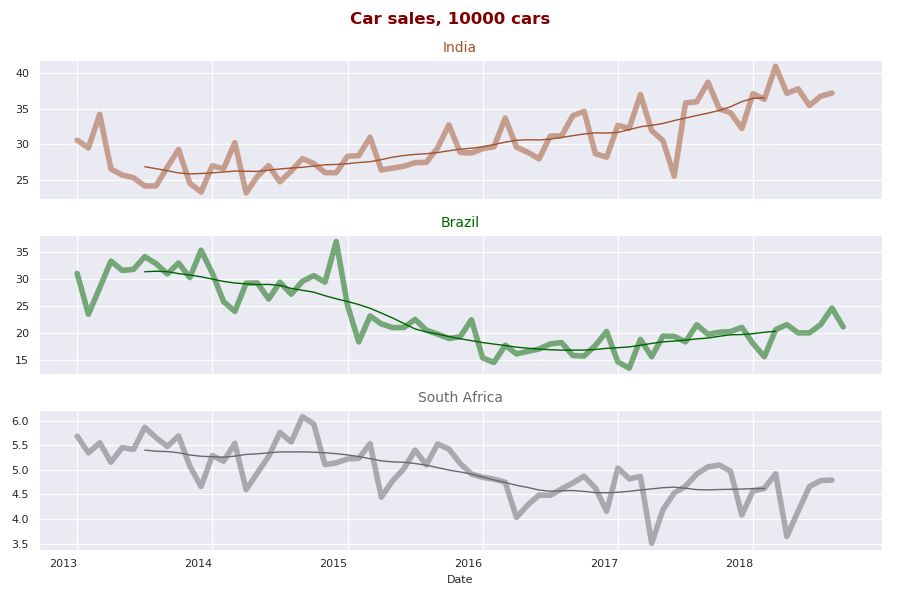

In [121]:
plot_triple(country4, ['India', 'Brazil', 'South Africa'], ['sienna', 'darkgreen', 'dimgrey']).savefig(r'/home/egor/Изображения/car_sales_ind_bra_sar.png')

## 2. Car production (https://auto.vercity.ru/statistics/production/)
###  For Russia

https://auto.vercity.ru/statistics/production/europe/2018/russia/

In [17]:
prod_df=pd.concat([GetYearsSalesData(Y, strSource=strCarProdsQ) for Y in range(2010, 2019)], axis=1) 

prod_df=prod_df.stack().reset_index().rename(columns={'level_0':'Model', 'level_1':'date', 0:'Count'})
prod_df['Count']=prod_df['Count'].apply(pd.to_numeric)

print(prod_df.head(10))

prod_df=prod_df[prod_df['Count']!=0]

#prod_df.to_sql('production_ru', con=conn, if_exists='replace', index=False)

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


  Model      date  Count
0   BAW  Jan-2010      0
1   BAW  Feb-2010      0
2   BAW  Mar-2010      0
3   BAW  Apr-2010      0
4   BAW  May-2010      0
5   BAW  Jun-2010      0
6   BAW  Jul-2010      0
7   BAW  Aug-2010      0
8   BAW  Sep-2010      0
9   BAW  Oct-2010      0


## For Ukraine

### Sales

In [24]:
sales_df_uk=pd.concat([GetYearsSalesData(Y, country='ukraine') for Y in range(2011, 2019)], axis=1) 

sales_df_uk=sales_df_uk.stack().reset_index().rename(columns={'level_0':'Model', 'level_1':'date', 0:'Count'})
sales_df_uk['Count']=sales_df_uk['Count'].apply(pd.to_numeric)

sales_df_uk=sales_df_uk[sales_df_uk['Count']!=0]

print(sales_df_uk.head(10))

sales_df_uk.to_sql('sales_ukraine', con=conn, if_exists='replace', index=False)

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


  Model      date  Count
0  Audi  Jan-2011     75
1  Audi  Feb-2011     99
2  Audi  Mar-2011    118
3  Audi  Apr-2011    101
4  Audi  May-2011     97
5  Audi  Jun-2011    128
6  Audi  Jul-2011    126
7  Audi  Aug-2011    161
8  Audi  Sep-2011    173
9  Audi  Oct-2011    130


### Production

In [26]:
prod_df_uk=pd.concat([GetYearsSalesData(Y, strSource=strCarProdsQ, country='ukraine') for Y in range(2010, 2019)], axis=1) 

prod_df_uk=prod_df_uk.stack().reset_index().rename(columns={'level_0':'Model', 'level_1':'date', 0:'Count'})
prod_df_uk['Count']=prod_df_uk['Count'].apply(pd.to_numeric)

prod_df_uk=prod_df_uk[prod_df_uk['Count']!=0]
print(prod_df_uk.head(10))
print(prod_df_uk['Model'].unique().tolist())
prod_df_uk.to_sql('production_ukraine', con=conn, if_exists='replace', index=False)

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


    Model      date  Count
15  Chery  Apr-2011    240
16  Chery  May-2011    720
17  Chery  Jun-2011    360
18  Chery  Jul-2011    480
19  Chery  Aug-2011    720
20  Chery  Sep-2011    840
21  Chery  Oct-2011    960
22  Chery  Nov-2011    960
23  Chery  Dec-2011    600
24  Chery  Jan-2012    240
['Chery', 'Chevrolet', 'Isuzu', 'Kia', 'Lada', 'Naza', 'Skoda', 'Tata', 'БАЗ', 'Богдан', 'ЗАЗ', 'КрАЗ', 'ЛАЗ', 'ЧАЗ']


## Germany

### Sales

In [44]:
sales_df_ger=pd.concat([GetYearsSalesData(Y, country='germany') for Y in range(2010, 2019)], axis=1) 

sales_df_ger=sales_df_ger.stack().reset_index().rename(columns={'level_0':'Model', 'level_1':'date', 0:'Count'})
sales_df_ger['Count']=sales_df_ger['Count'].apply(pd.to_numeric)

sales_df_ger=sales_df_ger[sales_df_ger['Count']!=0]

print(sales_df_ger.head(10))

sales_df_ger.to_sql('sales_germany', con=conn, if_exists='replace', index=False)

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


       Model      date  Count
0  AlfaRomeo  Jan-2010    493
1  AlfaRomeo  Feb-2010    530
2  AlfaRomeo  Mar-2010    513
3  AlfaRomeo  Apr-2010    642
4  AlfaRomeo  May-2010    503
5  AlfaRomeo  Jun-2010    832
6  AlfaRomeo  Jul-2010    771
7  AlfaRomeo  Aug-2010    798
8  AlfaRomeo  Sep-2010    865
9  AlfaRomeo  Oct-2010    963


### Production

In [45]:
prod_df_ger=pd.concat([GetYearsSalesData(Y, strSource=strCarProdsQ, country='germany') for Y in range(2010, 2019)], axis=1) 

prod_df_ger=prod_df_ger.stack().reset_index().rename(columns={'level_0':'Model', 'level_1':'date', 0:'Count'})
prod_df_ger['Count']=prod_df_ger['Count'].apply(pd.to_numeric)

prod_df_ger=prod_df_ger[prod_df_ger['Count']!=0]
print(prod_df_ger.head(10))
print(prod_df_ger['Model'].unique().tolist())
prod_df_ger.to_sql('production_germany', con=conn, if_exists='replace', index=False)

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


  Model      date  Count
0  Audi  Jan-2010  58061
1  Audi  Feb-2010  63281
2  Audi  Mar-2010  97635
3  Audi  Apr-2010  74743
4  Audi  May-2010  76752
5  Audi  Jun-2010  72899
6  Audi  Jul-2010  66516
7  Audi  Aug-2010  51671
8  Audi  Sep-2010  83047
9  Audi  Oct-2010  83333
['Audi', 'BMW', 'Ford', 'Maybach', 'Mercedes-Benz', 'Opel', 'Porsche', 'Seat', 'Volkswagen']


## France

### sales

In [ ]:
sales_df_fra=pd.concat([GetYearsSalesData(Y, country='france') for Y in range(2010, 2019)], axis=1) 

sales_df_ger=sales_df_ger.stack().reset_index().rename(columns={'level_0':'Model', 'level_1':'date', 0:'Count'})
sales_df_ger['Count']=sales_df_ger['Count'].apply(pd.to_numeric)

sales_df_ger=sales_df_ger[sales_df_ger['Count']!=0]

print(sales_df_ger.head(10))

sales_df_ger.to_sql('sales_germany', con=conn, if_exists='replace', index=False)